# 1D Sedov Blast

# Post-processing: plot and analyze the results

In [3]:
import meshio
import numpy as np
import glob, os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LogNorm
from matplotlib import mathtext
import math
from scipy import stats 


In [4]:
# Plot parameters
params = {
    "axes.labelsize": 11,
    "axes.titlesize": 11,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "text.usetex": False,
    "figure.figsize": (9, 6.45),
    "figure.subplot.left": 0.045,
    "figure.subplot.right": 0.99,
    "figure.subplot.bottom": 0.05,
    "figure.subplot.top": 0.99,
    "figure.subplot.wspace": 0.15,
    "figure.subplot.hspace": 0.12,
    "lines.markersize": 6,
    "lines.linewidth": 3.0,
}
plt.rcParams.update(params)
plt.rc('font', family='serif')
#plt.rc('text', usetex=False)

## Analytical solution (from Swift)

Computes the analytical solution of the 2D Sedov blast wave. Taken from `swiftsim/examples/HydroTests/SedovBlast_1D`

In [5]:
from scipy.special import gamma as Gamma

def calc_a(g, nu=3):
    """ 
    exponents of the polynomials of the sedov solution
    g - the polytropic gamma
    nu - the dimension
    """
    a = [0] * 8

    a[0] = 2.0 / (nu + 2)
    a[2] = (1 - g) / (2 * (g - 1) + nu)
    a[3] = nu / (2 * (g - 1) + nu)
    a[5] = 2 / (g - 2)
    a[6] = g / (2 * (g - 1) + nu)

    a[1] = (((nu + 2) * g) / (2.0 + nu * (g - 1.0))) * (
        (2.0 * nu * (2.0 - g)) / (g * (nu + 2.0) ** 2) - a[2]
    )
    a[4] = a[1] * (nu + 2) / (2 - g)
    a[7] = (2 + nu * (g - 1)) * a[1] / (nu * (2 - g))
    return a

def calc_beta(v, g, nu=3):
    """ 
    beta values for the sedov solution (coefficients of the polynomials of the similarity variables) 
    v - the similarity variable
    g - the polytropic gamma
    nu- the dimension
    """

    beta = (
        (nu + 2)
        * (g + 1)
        * np.array(
            (
                0.25,
                (g / (g - 1)) * 0.5,
                -(2 + nu * (g - 1))
                / 2.0
                / ((nu + 2) * (g + 1) - 2 * (2 + nu * (g - 1))),
                -0.5 / (g - 1),
            ),
        )
    )

    beta = np.outer(beta, v)

    beta += (g + 1) * np.array(
        (
            0.0,
            -1.0 / (g - 1),
            (nu + 2) / ((nu + 2) * (g + 1) - 2.0 * (2 + nu * (g - 1))),
            1.0 / (g - 1),
        ),
    ).reshape((4, 1))

    return beta


def sedov(t, E0, rho0, g, n=10000, nu=3):
    """ 
    solve the sedov problem
    t - the time
    E0 - the initial energy
    rho0 - the initial density
    n - number of points (10000)
    nu - the dimension
    g - the polytropic gas gamma
    """
    # the similarity variable
    v_min = 2.0 / ((nu + 2) * g)
    v_max = 4.0 / ((nu + 2) * (g + 1))

    v = v_min + np.arange(n) * (v_max - v_min) / (n - 1.0)

    a = calc_a(g, nu)
    beta = calc_beta(v, g=g, nu=nu)
    lbeta = np.log(beta)

    r = np.exp(-a[0] * lbeta[0] - a[2] * lbeta[1] - a[1] * lbeta[2])
    rho = ((g + 1.0) / (g - 1.0)) * np.exp(
        a[3] * lbeta[1] + a[5] * lbeta[3] + a[4] * lbeta[2]
    )
    p = np.exp(nu * a[0] * lbeta[0] + (a[5] + 1) * lbeta[3] + (a[4] - 2 * a[1]) * lbeta[2])
    u = beta[0] * r * 4.0 / ((g + 1) * (nu + 2))
    p *= 8.0 / ((g + 1) * (nu + 2) * (nu + 2))

    # we have to take extra care at v=v_min, since this can be a special point.
    # It is not a singularity, however, the gradients of our variables (wrt v) are.
    # r -> 0, u -> 0, rho -> 0, p-> constant

    u[0] = 0.0
    rho[0] = 0.0
    r[0] = 0.0
    p[0] = p[1]

    # volume of an n-sphere
    vol = (np.pi ** (nu / 2.0) / Gamma(nu / 2.0 + 1)) * np.power(r, nu)

    # note we choose to evaluate the integral in this way because the
    # volumes of the first few elements (i.e near v=vmin) are shrinking
    # very slowly, so we dramatically improve the error convergence by
    # finding the volumes exactly. This is most important for the
    # pressure integral, as this is on the order of the volume.

    # (dimensionless) energy of the model solution
    de = rho * u * u * 0.5 + p / (g - 1)
    # integrate (trapezium rule)
    q = np.inner(de[1:] + de[:-1], np.diff(vol)) * 0.5

    # the factor to convert to this particular problem
    fac = (q * (t ** nu) * rho0 / E0) ** (-1.0 / (nu + 2))

    # shock speed
    shock_speed = fac * (2.0 / (nu + 2))
    rho_s = ((g + 1) / (g - 1)) * rho0
    r_s = shock_speed * t * (nu + 2) / 2.0
    p_s = (2.0 * rho0 * shock_speed * shock_speed) / (g + 1)
    u_s = (2.0 * shock_speed) / (g + 1)

    r *= fac * t
    u *= fac
    p *= fac * fac * rho0
    rho *= rho0
    return r, p, rho, u, r_s, p_s, rho_s, u_s, shock_speed

## Radial profiles

In [14]:
from tkinter import Tcl

!pwd
# Import snapshots
snapshot_number = 20
snapshot_dir = 'output/snapshots/'
#snapshot_dir = 'Npart_63_h_constant/'
#snapshot_dir = 'Npart_63_blast_energy_0_2/'
#snapshot_dir = 'Npart_63_non-smoothing/'
files = glob.glob(snapshot_dir + "particles*.vtu")
# Sort the snapshots according to Natural sort
files = Tcl().call('lsort', '-dict', files)

# Parameters
time_step_sim = 1e-5
snapshot_rate = 20
time = snapshot_number*snapshot_rate*time_step_sim

neighbours = 4.28
eta = 1.235
kernel = 'Cubic Spline (M4)'
scheme = 'Minimal SPH'


snapshot = files[snapshot_number]
print('Reading snapshot: ' + snapshot )
print("time of simulation = ", time)
print("********************************************")

mesh = meshio.read( snapshot )
print(mesh.point_data_to_sets)
print("********************************************")

# Extract Fields
pos = mesh.point_data["x"]
x = pos[:,0] - 0.5
y = pos[:,1] - 0.5
vel = mesh.point_data["v"]
vel_x   = vel[:,0] 
vel_y   = vel[:,1] 
r = np.sqrt(x**2 + y**2)
v_r = (x*vel_x + y*vel_y)/r
density = mesh.point_data["density"][:,0]
pressure= mesh.point_data["pressure"][:,0]
mass    = mesh.point_data["mass"][:,0]
energy  = mesh.point_data["u"][:,0]

print("Measure energy conservation:")
#E_ini = 5.0000014
E_ini = 1.0000014
#E_ini = 0.075
E_kin = mass[0] * np.sum( 0.5 * (vel_x**2 + vel_y**2) )
E_int = mass[0] * np.sum(energy)
E_tot = E_kin + E_int
E_dif = (E_tot - E_ini)/E_ini
print("Initial E=", E_ini, "Total E= ", E_tot, "Kinetic E=", E_kin, "Internal E=", E_int)
print("Relative Energy difference = ", E_dif )
print("********************************************")

# Filter by position
#x_mask = np.less_equal( x, 0 )
x_mask = np.greater_equal( x, 0 )
y_min = -1e-2
y_max = 1e-2
y_mask = np.less_equal(y, y_max)
y_mask = y_mask & np.greater_equal(y, y_min)
pos_mask = x_mask & y_mask

x_line =  x[pos_mask]
y_line = y[pos_mask]
density_x = density[pos_mask]
pressure_x= pressure[pos_mask]
energy_x  = energy[pos_mask]
vel_x_line =  vel_x[pos_mask]

#print(x.shape, density.shape, x_line.shape, density_x.shape)
print('** ' + str(len(x_line)) + ' ** particles found with this filter.')

/home/cristianbarrahinojosa/Codes/Peano/benchmarks/swift2/hydro/Sedov_1D
Reading snapshot: output/snapshots/particles-20.vtu
time of simulation =  0.004
********************************************
<bound method Mesh.point_data_to_sets of <meshio mesh object>
  Number of points: 100
  Number of cells:
    vertex: 100
  Point data: x, cut-off-radius, association, partid, v, a, mass, density, pressure, u, smoothingLength, f, Ncount, isBoundaryParticle>
********************************************
Measure energy conservation:
Initial E= 1.0000014 Total E=  1.0037782 Kinetic E= 0.09627214 Internal E= 0.9075061
Relative Energy difference =  0.003776813935483022
********************************************
** 50 ** particles found with this filter.


/tmp/ipykernel_53429/2792293985.py:42: RuntimeWarning: invalid value encountered in true_divide
  v_r = (x*vel_x + y*vel_y)/r


In [15]:
# Parameters
rho_0 = 4.0                     # Background Density
P_0 = 6.6e-7                    # Background Pressure
u_0 = 1.0
E_0 = E_ini                     # Total Energy of the explosion
gas_gamma = 5.0/3.0             # Gas polytropic index

# The main properties of the solution
r_s, P_s, rho_s, v_s, r_shock, _, _, _, _ = sedov(time, E_0, rho_0, gas_gamma, 1000, 1)

# Append points for after the shock
r_s = np.insert(r_s, np.size(r_s), [r_shock, r_shock*3])
rho_s = np.insert(rho_s, np.size(rho_s), [rho_0, rho_0])
P_s = np.insert(P_s, np.size(P_s), [P_0, P_0])
v_s = np.insert(v_s, np.size(v_s), [0, 0])

# Additional arrays
u_s = P_s / (rho_s * (gas_gamma - 1.0))  # internal energy
s_s = P_s / rho_s ** gas_gamma           # entropic function

/tmp/ipykernel_53429/281826234.py:79: RuntimeWarning: divide by zero encountered in log
  lbeta = np.log(beta)
/tmp/ipykernel_53429/2265237157.py:18: RuntimeWarning: divide by zero encountered in true_divide
  u_s = P_s / (rho_s * (gas_gamma - 1.0))  # internal energy
/tmp/ipykernel_53429/2265237157.py:19: RuntimeWarning: divide by zero encountered in true_divide
  s_s = P_s / rho_s ** gas_gamma           # entropic function


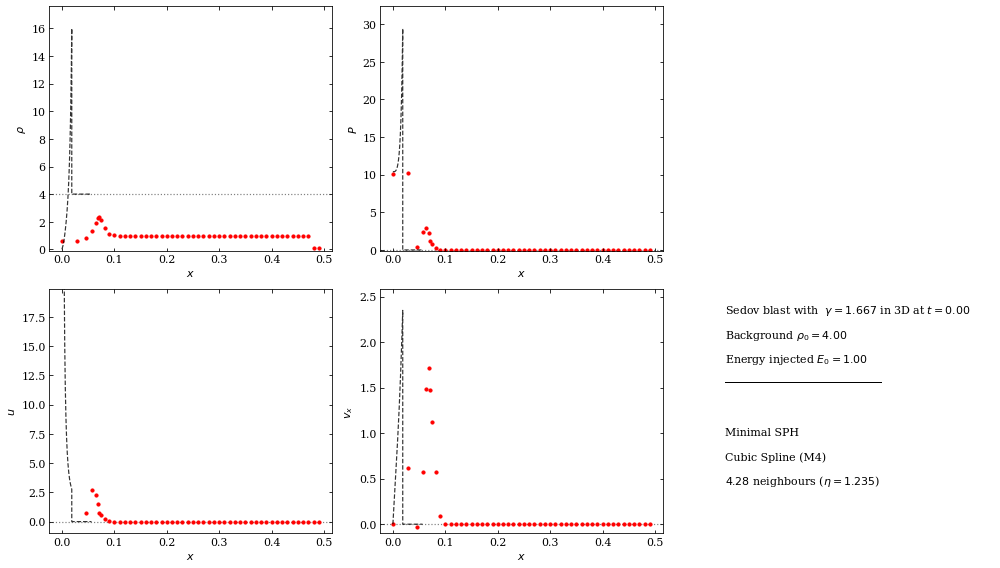

In [16]:
#### Plot radial profiles
fig = plt.figure(figsize=(14, 8)) 

plt.subplot(231)
plt.plot(r_s,rho_s, "--", color="k", alpha=0.8, lw=1.2)
plt.scatter(x_line, density_x, s=10, c='r', zorder=1)
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
plt.margins(0.05, 0.1)
plt.tick_params(direction='in', top=True, right=True)
plt.axhline(rho_0, c='gray', ls=':', lw=1.2,zorder=-49 )
#plt.axhline( (5./3.+1.)/(5./3.-1.)*rho_0, c='r', ls=':', lw=1.2,zorder=-49 )
#ax0.text(0.05, 0.85, r"$t=$" + str(time)[:5], fontsize=12,  transform=ax0.transAxes)
#ax0.text(0.05, 0.92, r"$N_{part}=$" + str(len(x_line)*2-1), fontsize=12,  transform=ax0.transAxes)
#plt.xlim(0.1 * r_shock, 1.5 * r_shock)
plt.ylim(-0.1, 1.1 * rho_s.max() )

plt.subplot(232)
plt.plot(r_s, P_s, "--", color="k", alpha=0.8, lw=1.2)
plt.scatter(x_line, pressure_x, s=10, c='r')
plt.axhline(0, c='gray', ls=':', lw=1.2,zorder=-49 )
plt.xlabel(r'$x$')
plt.ylabel(r'$P$')
plt.margins(0.05, 0.1)
plt.tick_params(direction='in', top=True, right=True)
#plt.xlim(0.1 * r_shock, 1.5 * r_shock)
plt.ylim(-0.1, 1.1 * P_s.max() )

plt.subplot(234)
plt.plot(r_s, u_s, "--", color="k", alpha=0.8, lw=1.2)
plt.scatter(x_line, energy_x, s=10, c='r')
plt.axhline(0, c='gray', ls=':', lw=1.2,zorder=-49 )
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.margins(0.05, 0.1)
plt.tick_params(direction='in', top=True, right=True)
#plt.xlim(0.1 * r_shock, 1.5 * r_shock)
plt.ylim(-1, 1.1 * u_s[10:].max() )

plt.subplot(235)
plt.plot(r_s, v_s, "--", color="k", alpha=0.8, lw=1.2)
plt.scatter(x_line, vel_x_line, s=10, c='r')
plt.axhline(0, c='gray', ls=':', lw=1.2,zorder=-49 )
plt.xlabel(r'$x$')
plt.ylabel(r'$v_x$')
plt.margins(0.05, 0.1)
plt.tick_params(direction='in', top=True, right=True)
#plt.xlim(0.1 * r_shock, 1.5 * r_shock)
plt.ylim(-0.1, 1.1 * v_s[10:].max() )


# Information -------------------------------------

plt.subplot(236, frameon=False)

plt.text(
    -0.45,
    0.9,
    "Sedov blast with  $\\gamma=%.3f$ in 3D at $t=%.2f$" % (gas_gamma, time),
    fontsize=11,
)
plt.text(-0.45, 0.8, "Background $\\rho_0=%.2f$" % (rho_0), fontsize=11)
plt.text(-0.45, 0.7, "Energy injected $E_0=%.2f$" % (E_0), fontsize=11)

plt.plot([-0.45, 0.1], [0.62, 0.62], "k-", lw=1)
plt.text(-0.45, 0.4, scheme, fontsize=11)
plt.text(-0.45, 0.3, kernel, fontsize=11)
plt.text(
    -0.45,
    0.2,
    "$%.2f$ neighbours ($\\eta=%.3f$)" % (neighbours, eta),
    fontsize=11,
)
plt.xlim(-0.5, 0.5)
plt.ylim(0, 1)
plt.xticks([])
plt.yticks([])

plt.tight_layout()

plt.show()
#fig.savefig( "profile_Sedov_" + "snap_" + str(snapshot_number) + ".pdf", bbox_inches='tight')
plt.close()

## Smoothing length histogram

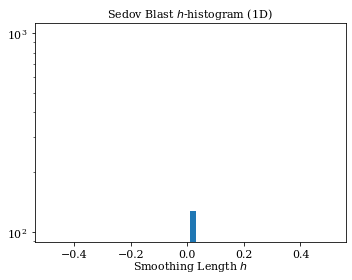

In [10]:
SmoothingLength = mesh.point_data["smoothingLength"][:,0]

h_bins = 50

fig = plt.figure(figsize=(5, 4)) 

plt.hist(SmoothingLength, bins=h_bins)
plt.semilogy()
#plt.ylabel("Counts", labelpad=0)
plt.xlabel("Smoothing Length $h$", labelpad=0)
plt.title('Sedov Blast $h$-histogram (1D)')

plt.tight_layout()

plt.show()
#fig.savefig( "h_histogram_SedovBlast1D_" + "snap_" + str(snapshot_number) + ".pdf", bbox_inches='tight')
plt.close()

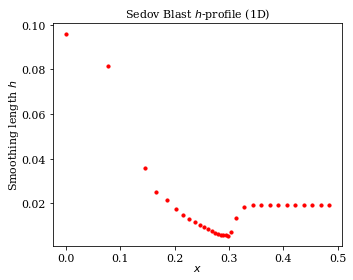

In [13]:
h_line = SmoothingLength[pos_mask]
fig = plt.figure(figsize=(5, 4)) 
plt.scatter(x_line, h_line, s=10, c='r', zorder=1)
plt.ylabel("Smoothing length $h$", labelpad=0)
plt.xlabel("$x$", labelpad=0)
plt.title('Sedov Blast $h$-profile (1D)')

plt.tight_layout()

plt.show()
#fig.savefig( "h_profile_Sedov_" + "snap_" + str(snapshot_number) + ".pdf", bbox_inches='tight')
plt.close()

In [83]:
delta_swift = 2.329739e-01 + 7.660489e-01

In [84]:
1-delta_swift

0.0009771999999999004